In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
plt.rcParams['font.size'] = 14
#import pylab_util as PU
import os
fft = np.fft.fft
import bode_utils
import txt_mixin

In [2]:
def data_to_float_array(data):
    mylist = data.split('\n')
    clean_list = mylist#[3:]
    clean_2 = list(filter(None,clean_list))
    
    start_ind = None
    
    for i, row in enumerate(clean_2):
        if row.find("1,") == 0:
            start_ind = i
    
    end_ind = None
    
    for i, row in enumerate(clean_2):
        if row.find("input") > -1:
            end_ind = i
            
    clean_3 = clean_2[start_ind:end_ind]
    nested_list = [row.split(',') for row in clean_3]
    str_array = np.array(nested_list)
    float_array = str_array.astype(float)
    return float_array
    #return str_array

In [3]:
import control
#import digcomp

In [4]:
import serial
import serial_utils

In [5]:
import importlib

In [6]:
importlib.reload(serial_utils)

<module 'serial_utils' from '/Users/kraussry/git/research/serial_utils.py'>

In [7]:
import platform

In [8]:
plat_str = platform.platform().lower()
plat_str

'darwin-14.5.0-x86_64-i386-64bit'

In [9]:
myos = 'win'

if 'linux' in plat_str:
    myos = 'linux'
elif 'darwin' in plat_str:
    myos = 'mac'

print('myos: %s' % myos)

myos: mac


In [10]:
if myos == 'linux':
    portname = serial_utils.find_portname_RPi()
elif myos == 'mac':
    #portname = '/dev/tty.usbmodem1421'
    portname = '/dev/cu.usbmodem1411'
else:
    portname = 'COM3'
    
print('portname: %s' % portname)

portname: /dev/cu.usbmodem1411


In [11]:
ser = serial_utils.serial_test(portname)

In [12]:
ser.open()

In [13]:
ser.print_all()

krauss balancing v. 1.1.0
input test case




In [14]:
ser.flush()

In [15]:
ser.print_all()

In [16]:
ser.write_char("s")
ser.write_int(2000)

In [17]:
ser.print_all()

stop_n = 2000
input test case




In [20]:
ser.write_char("/")
ser.write_float(0.005)

In [21]:
ser.print_all()

accel_frac = 0.005000
input test case




In [22]:
ser.write_char("z")

In [24]:
ser.print_all()

zeroing done
ay_offset = -99
input test case




In [25]:
ser.write_char("1")
#time.sleep(1)
data = ser.get_data()

In [26]:
data2 = ser.get_data()

In [27]:
data += data2

In [28]:
data_array = data_to_float_array(data)

In [29]:
data_array.shape

(2001, 10)

      Serial.print(n_loop);Serial.print(",");   
      Serial.print(t_ms);Serial.print(",");    
      Serial.print(AcY);Serial.print(",");
      Serial.print(AcY_offset);Serial.print(",");
      Serial.print(AcZ);Serial.print(",");
      Serial.print(roll);Serial.print(",");
      Serial.print(gyroXrate);Serial.print(",");
      Serial.print(compAngleX);//Serial.print(",");
      //---------------------------------
      Serial.print('\n');


In [30]:
default_col_list = ['n','t_ms','AcY','AcY_offset','AcZ','roll', \
                    'gyroXrate','compX','e','edot']

class filter_investigation(object):
    def __init__(self, data_array, col_list=None):
        self.data = data_array
        
        if col_list is None:
            col_list = default_col_list
        self.col_list = col_list
        
        self.extract_cols()
        self.t = self.t_ms/1000
        
        
    def extract_cols(self):
        N = len(default_col_list)
        
        for i in range(N):
            cur_attr = self.col_list[i]
            cur_col = self.data[:,i]
            setattr(self,cur_attr,cur_col)
            
    def gyro_int(self):
        """Pure numeric integration of the gyro rate without 
        the complimentary filter."""
        #compAngleX = 0.99 * (compAngleX + gyroXrate * dt_sec)
        N = len(self.gyroXrate)
        theta_X_pure_int = np.zeros(N)
        
        for i in range(1,N):
            prev_th = theta_X_pure_int[i-1]
            dt_i = self.t[i] - self.t[i-1]
            next_th = prev_th + self.gyroXrate[i]*dt_i
            theta_X_pure_int[i] = next_th
            
        self.theta_X_pure_int = theta_X_pure_int
            
            
    def _plot(self, attr_list):
        if type(attr_list) == str:
            attr_list = [attr_list]
        plt.figure()
        
        t = self.t
        
        for attr in attr_list:
            cur_vect = getattr(self, attr)
            plt.plot(t,cur_vect, label=attr)
            plt.xlabel('Time (sec.)')
            plt.ylabel('Signal Amplitude')
            
            
    def save(self, filename):
        txt_mixin.dump_delimited(filename, self.data, \
                                 labels=self.col_list)
                                 #delim='\t', fmt='%s', 
        

In [31]:
myfilt = filter_investigation(data_array)
myfilt.gyro_int()

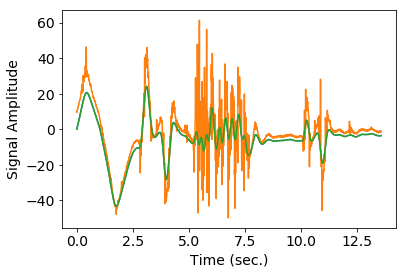

In [32]:
myfilt._plot(['compX','roll','e'])
#plt.xlim([0,6])

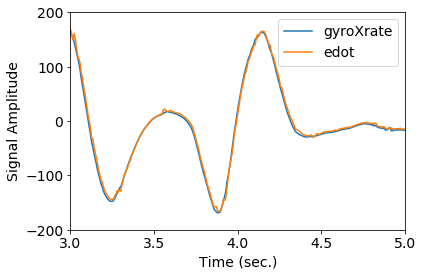

In [33]:
myfilt._plot(['gyroXrate','edot'])
plt.xlim([3,5])
plt.ylim([-200,200])
plt.legend(['gyroXrate','edot'])

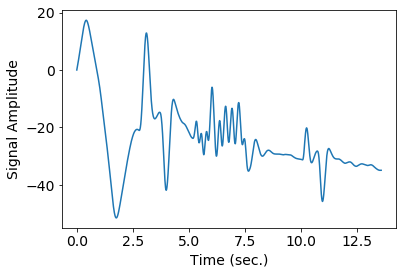

In [34]:
myfilt._plot(['theta_X_pure_int'])

In [35]:
myfilt.save('krauss_filt_1.csv')

In [36]:
pwd

'/Users/kraussry/Google Drive/Teaching/SBR_independent_study/EGR499_W18_SBR_ind_study_class_folder/krauss_code'